<a href="https://colab.research.google.com/github/khangsheng1/PyTorch-Tutorial/blob/main/PyTorch_Tutorial_FashionMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [2]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

print(training_data)

print(test_data)

100%|██████████| 26421880/26421880 [00:02<00:00, 8917280.75it/s] 


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 192583.64it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3760751.72it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 22538911.27it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()


In [3]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


In [4]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cuda device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [5]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [6]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [7]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [8]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.308610  [   64/60000]
loss: 0.587021  [ 6464/60000]
loss: 0.400862  [12864/60000]
loss: 0.495760  [19264/60000]
loss: 0.466537  [25664/60000]
loss: 0.427576  [32064/60000]
loss: 0.370912  [38464/60000]
loss: 0.545251  [44864/60000]
loss: 0.467532  [51264/60000]
loss: 0.540062  [57664/60000]
Test Error: 
 Accuracy: 84.2%, Avg loss: 0.425561 

Epoch 2
-------------------------------
loss: 0.262494  [   64/60000]
loss: 0.354749  [ 6464/60000]
loss: 0.274280  [12864/60000]
loss: 0.410967  [19264/60000]
loss: 0.417957  [25664/60000]
loss: 0.400567  [32064/60000]
loss: 0.299526  [38464/60000]
loss: 0.518125  [44864/60000]
loss: 0.381175  [51264/60000]
loss: 0.474875  [57664/60000]
Test Error: 
 Accuracy: 86.0%, Avg loss: 0.383041 

Epoch 3
-------------------------------
loss: 0.213281  [   64/60000]
loss: 0.327129  [ 6464/60000]
loss: 0.236822  [12864/60000]
loss: 0.353102  [19264/60000]
loss: 0.358300  [25664/60000]
loss: 0.357957  [32064/600

In [9]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


In [10]:
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load("model.pth", weights_only=True))

<All keys matched successfully>

In [16]:
len(test_data)

10000

We are testing #6281 out of 10000 from the FashionMNIST dataset:
We are testing #1076 out of 10000 from the FashionMNIST dataset:
We are testing #883 out of 10000 from the FashionMNIST dataset:
We are testing #4385 out of 10000 from the FashionMNIST dataset:


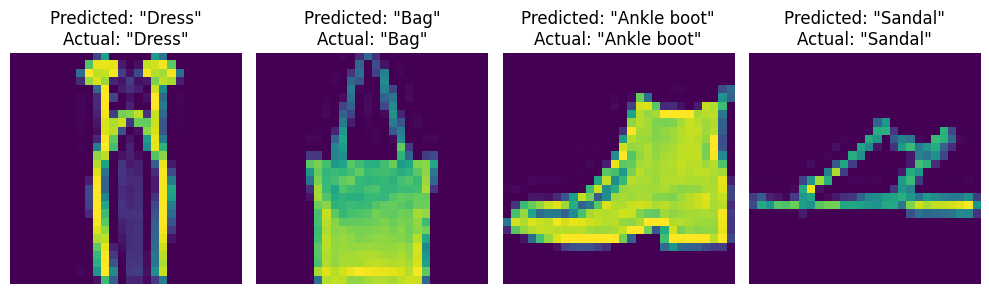

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
%matplotlib inline


classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

num_iter = 4  # Number of images to test
fig, axs = plt.subplots(1, num_iter, figsize=(10, 3))  # Create subplots (1 row, num_iter columns)

for i in range(num_iter):
    # Generate a random number
    test_num = random.randint(0, 10000)

    model.eval()
    x, y = test_data[test_num][0], test_data[test_num][1]

    # Display image in a subplot
    print(f'We are testing #{test_num} out of 10000 from the FashionMNIST dataset:')
    axs[i].imshow(x.reshape(28, 28))  # Plot in the ith subplot
    axs[i].axis('off')  # Turn off axis for cleaner look

    with torch.no_grad():
        x = x.to(device)
        pred = model(x)
        predicted, actual = classes[pred[0].argmax(0)], classes[y]
        axs[i].set_title(f'Predicted: "{predicted}"\nActual: "{actual}"')  # Set title for the subplot

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()